# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Introduction to Data Science

## Lab 6:  Feed Forward Neural Networks 3 - Optimizers and Regularization

**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas<br/>
**Lab Team**: Eleni Kaxiras, Marios Mattheakis, Chris Gumb, Shivas Jayaram
<br/>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### Table of Contents
- JupyterHub
- Keras Functional API
- Weight Initializers 
- Optimizers
    - SGD
    - Adagrad
    - RMProp
    - Adam
- Batchnorm 
- Regularization (15)
    - Early Stopping
    - Norm Penalties
    - Dropout
    - Data Augmentation
- Data Generators (15)
- Activity 2 (15)

In [2]:
%matplotlib inline 
import copy
import operator
import numpy as np
import pandas as pd
import tensorflow as tf
import random as rn
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# You can adjust the notebook width if you like
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [4]:
# Recite the sacred reproducibility incantation
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(109)
np.random.seed(109)
rn.seed(109)

## JupyterHub

JupyterHub-GPU is a Jupyter Notebook server with all packages defined in the `cs109b.yml` installed. Instances running on this server have access to GPU acceleration, making training neural networks much faster!

**Launching JupyterHub-GPU**

1. Select "JupyterHub-GPU" from the navigation bar on the Canvas course page.

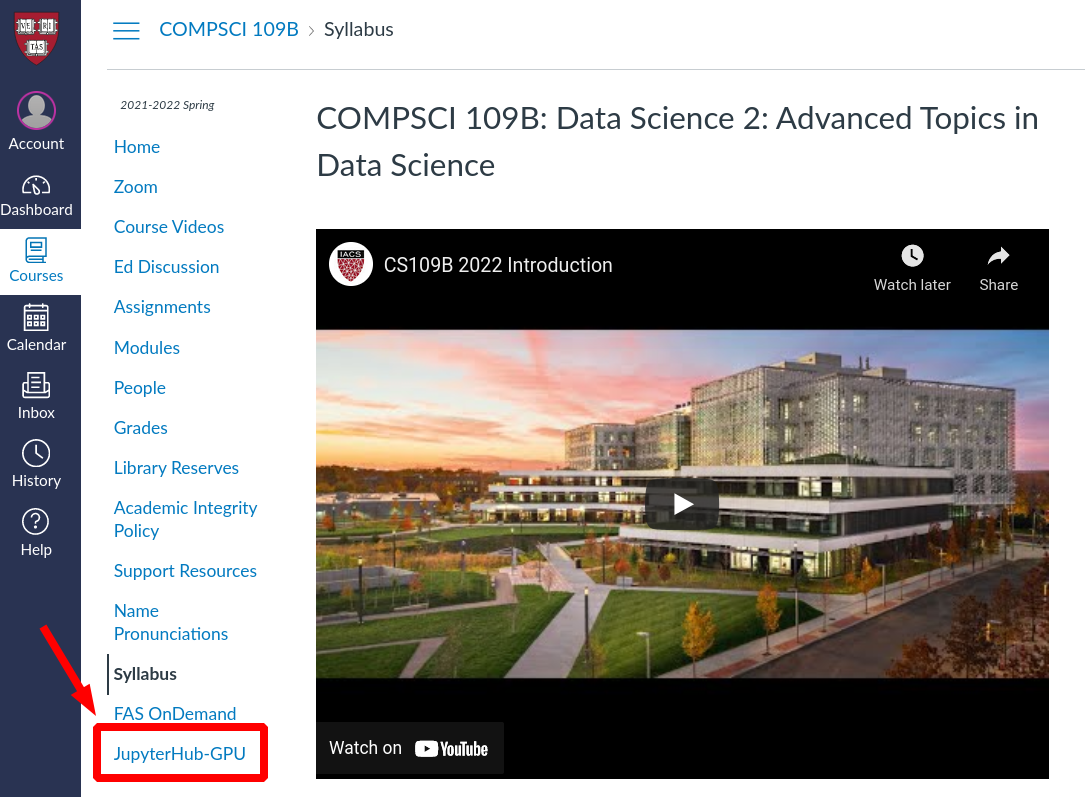

Wait a minute form your server to start up...

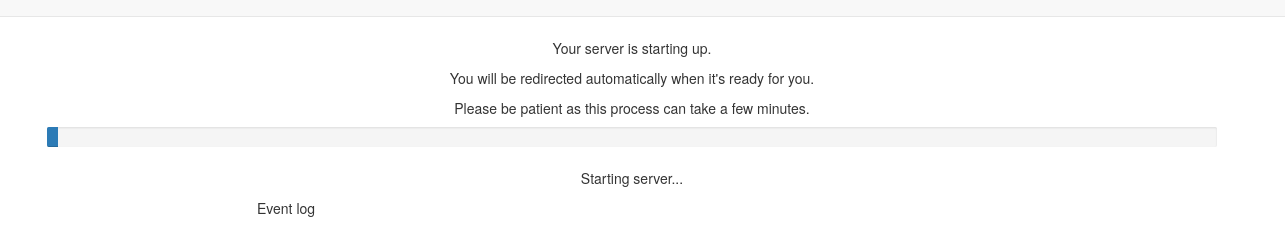

You'll then be greeted with the familar, classic Jupyter Notebook file browsers. From here you can:
- Create folders and naviate the file structure
- Launch Jupyter Notebooks
- Upload files manually
- Launch a new terminal which is helpful for:
    - unziping files
    - running git commands
    - or executing arbitrary shell commands

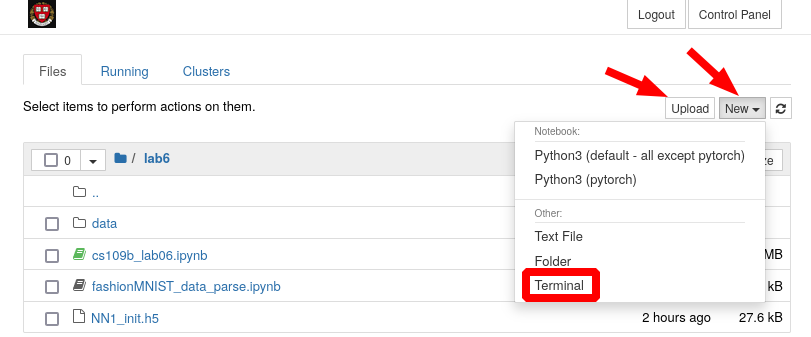

To run this lab on JupyterHub, simply launch a new terminal and clone the public course repo with the command:
```
git clone https://github.com/Harvard-IACS/2022-CS109B
```
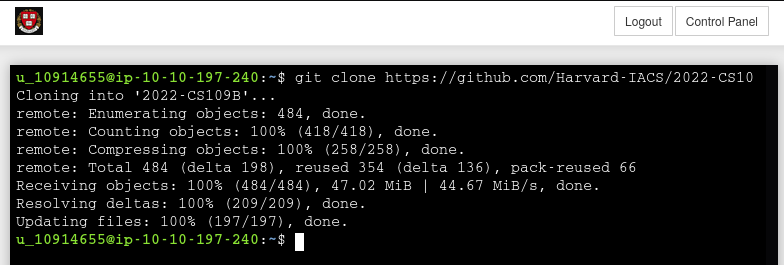

If you want to run the cells in the 1st half of this lab, they run _much_ faster with the GPU acceleration.\

One weakness of the JupyterHub server is slow disk read & write speeds. So if you decide to use the Datagenerators at the end of the notebook (which requires files be read from disk each batch) then you may find it runs just as fast (if not faster) on your local machine. We'll see an alternative to Datagenerators that circumvent this issue in lab 7.

## Part 1 - Regression with Neural Networks

Let's fit a difficult function where polynomial regression fails. 

The [dielectric function](https://en.wikipedia.org/wiki/Permittivity) of many optical materials depends on the frequency and is given by the Lorentz model as:
$$ \varepsilon(\omega) = 1 - \frac{\omega_0^2}{\omega_0^2-\omega^2 +i\omega\Gamma},$$
where $\omega$ is the frequency, $\omega_0$ is the resonance frequency of the bound electrons, and $\Gamma$ is the electron damping. 

In many situations, we measure the real part of the dielectric function in the lab and then we fit these observations. Let's assume that we perform an experiment and the observations came from a Lorentz model.

In [5]:
df = pd.read_csv('data/lorentz_set.csv').sample(frac=1, random_state=109) # shuffle DataFrame!
x_train, x_test, y_train, y_test = train_test_split(df.x, df.y, train_size=0.7, random_state=109)

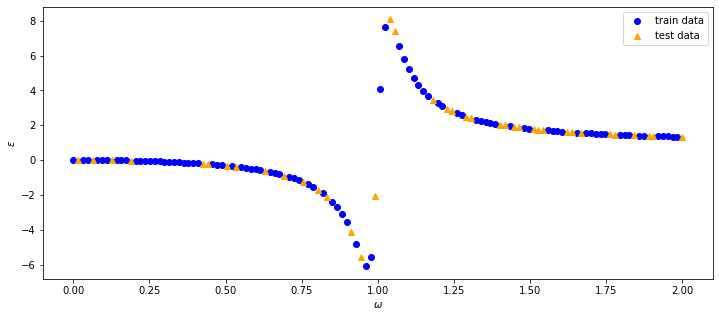

In [6]:
def plot_lorentz(df, test_idx, ax=None):
    if ax is None:
        ax = plt.gca()
    train_mask = np.ones(df.shape[0], dtype=bool)
    train_mask[test_idx] = False
    ax.scatter(df.x[train_mask],df.y[train_mask], c='b', label='train data')
    ax.scatter(df.x[~train_mask],df.y[~train_mask], c='orange', marker='^', label='test data')
    ax.set_xlabel('$\omega$')
    ax.set_ylabel('$\epsilon$')
    ax.legend()

plt.figure(figsize = (12,5));
plot_lorentz(df, x_test.index);

MSE on training set:  1.1064734497354518
MSE on testing set:  1.9984072025269768


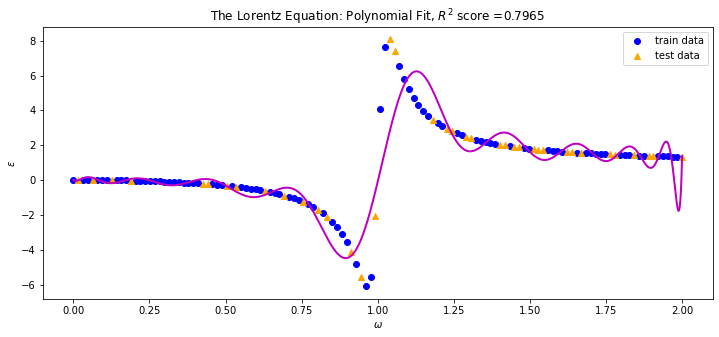

In [7]:
polynomial_features= PolynomialFeatures(degree=25)
x_poly_train = polynomial_features.fit_transform(x_train.values.reshape(-1,1))
x_poly_test = polynomial_features.fit_transform(x_test.values.reshape(-1,1))

model = LinearRegression()
model.fit(x_poly_train, y_train)
y_poly_train = model.predict(x_poly_train)
y_poly_test = model.predict(x_poly_test)

mse_train_poly = mean_squared_error(y_train, y_poly_train)
mse_test_poly = mean_squared_error(y_test, y_poly_test)
print('MSE on training set: ', mse_train_poly)
print('MSE on testing set: ', mse_test_poly)

x_lin = np.linspace(x_train.min(), x_train.max(), 1000)
x_lin_poly = polynomial_features.fit_transform(x_lin.reshape(-1,1))
y_poly_pred = model.predict(x_lin_poly)

plt.figure(figsize = (12,5))
ax = plt.gca()
plot_lorentz(df, x_test.index, ax=ax);
# plt.plot(x_train, y_train,'ob',label='train data')
# plt.scatter(x_test, y_test,c='orange', marker='^',label='train data')
ax.plot(x_lin, y_poly_pred, color='m',linewidth=2,label='polynomial model train')
ax.set_title("The Lorentz Equation: Polynomial Fit, $R^2$ score ={}".format(round(r2_score(y_train,y_poly_train),4)));

As expected, we get some wile behavior because we need a very high polynomial degree to begin to approximate this function.\

Let's see if we can do better using a **feed forward neural network**. We'll again be using Tensorflow's high-level Keras API. But this time we'll construct our NNs a bit differently...

## Keras Functional API

In [8]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

[Official Keras Guide](https://keras.io/guides/functional_api/)

The Keras functional API is a way to create models that are more flexible than the `tf.keras.Sequential API`. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers.

You create a node in the graph by instantiating a layer object. A directed connection is created between nodes by passing one node as input to another:
```{python}
inputs = Dense(...)
hidden1 = Dense(...)(inputs)
hidden2 = Dense(...)(hidden1)
output = Dense(...)(hidden2)
```
The model is created with the `tf.keras.Model` constructor, which requires args `inputs` and `outputs`, defining where the graph begins and where it ends.
```{python}
model = tf.keras.Model(inputs=inputs, outputs=outputs)
```

This flexibility allows you to have forking and merging paths in your network. We'll see more complex graph structures like later in the course!

In [9]:
inputs = Input(shape=(1,))
x = Dense(50, activation='tanh')(inputs)
x = Dense(50, activation='tanh')(x)
outputs = Dense(1, activation='linear')(x)
NN1 = Model(inputs=inputs, outputs=outputs, name='NN1')
NN1.save_weights('NN1_init.h5')
NN1.summary()

Model: "NN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


## Weight Initilizers

[`tf.keras.initializers`](https://keras.io/api/layers/initializers/)

In [10]:
from tensorflow.keras import initializers
from tensorflow.keras.initializers import glorot_normal, glorot_uniform, he_uniform, random_normal

The keyword arguments used for passing initializers to layers depends on the layer. Usually, it is simply `kernel_initializer` and `bias_initializer`.

As we've already seen with Keras objects like optimizers, losses, and metrics, all built-in initializers can also be passed via their string identifier (though this requires that you accept their default parameters if they have any).

The standard initializers you might expect are:
- Normal
- Truncated Normal
- Uniform
- Ones
- Zeros

Some more exotic initializers include:
- Glorot (a.k.a Xavier) normal initializer
    - Draws samples from a truncated normal distribution centered on 0 with `stddev = sqrt(2 / (fan_in + fan_out))` where `fan_in` is the number of input units in the weight tensor and `fan_out` is the number of output units in the weight tensor.
    - [Glorot et al., 2010](http://proceedings.mlr.press/v9/glorot10a.html)
- Glorot (a.k.a. Xavier) uniform initializer
    - Similar idea, except now the limits of the uniform are a function of `fan_in` and `fan_out`
- HeNormal
    - Just like Glorot normal except it only uses `fan_in`
    - [He et al., 2015](https://arxiv.org/abs/1502.01852)
- HeUniform
    - See above
    
As with everything (except possibly early stopping!) there is no free lunch here. The initializer is just another hyperparameter for you to experiment with. And they can indeed have an effect on your model's training, and therefore, its performance as well.

In [11]:
# Helper function for plotting training history
def plot_history(model, title=None, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.history.history['loss'], label='train')
    ax.plot(model.history.history['val_loss'], label='validation')
    ax.set_xlabel('epoch')
    ax.set_ylabel('MSE')
    best_loss = np.nanmin(model.history.history['val_loss'])
    ax.axvline(np.nanargmin(model.history.history['val_loss']),
                c='k', ls='--',
                label=f'best val loss = {best_loss:.2f}')
    ax.legend()
    ax.set_title(title)

Let's take a look at a few initializers and the resulting weight distributions in the first layer before and after training.

CPU times: total: 18.8 s
Wall time: 16.1 s


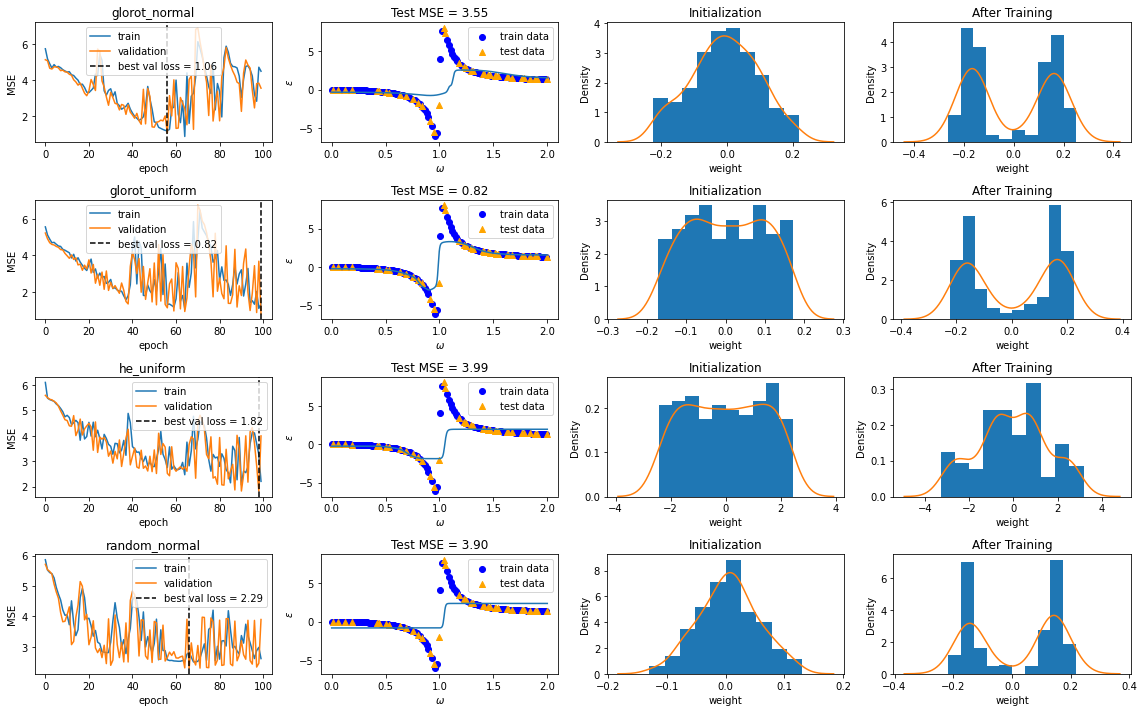

In [12]:
%%time
fig, axs = plt.subplots(4, 4, figsize=(16,10));
kernal_initilizers = ['glorot_normal', 'glorot_uniform', 'he_uniform', 'random_normal']

for i, kernel_initializer in enumerate(kernal_initilizers):
    # Build Model
    inputs = Input(shape=(1,))
    x = Dense(200, activation='tanh', kernel_initializer=kernel_initializer)(inputs)
    x = Dense(50, activation='tanh', kernel_initializer=kernel_initializer)(x)
    x = Dense(5, activation='tanh', kernel_initializer=kernel_initializer)(x)
    outputs = Dense(1, activation='linear', kernel_initializer=kernel_initializer)(x)
    NN1 = Model(inputs=inputs, outputs=outputs, name='NN1')
    # Compile
    NN1.compile(tf.keras.optimizers.Adam(learning_rate=0.01), 'mse')
    # Plot Initial Weights
    first_layer_weights = NN1.get_weights()[0][0]
    axs[i,2].hist(first_layer_weights, density=True)
    sns.kdeplot(first_layer_weights, ax=axs[i,2])
    axs[i,2].set_xlabel('weight')
    axs[i,2].set_title('Initialization')
    
    # Fit
    NN1.fit(x_train, y_train, 
            validation_data=(x_test, y_test),
            batch_size=32,
            epochs=100,
            verbose=0)
    # Plot
    # History
    plot_history(NN1, ax=axs[i,0], title=kernel_initializer)
    
    # Predictions
    y_hat = NN1.predict(x_test)
    mse = mean_squared_error(y_test, y_hat)
    x_lin = np.linspace(df.x.min(), df.x.max(), (500)).reshape(-1,1)
    y_hat_lin = NN1.predict(x_lin)
    axs[i,1].plot(x_lin, y_hat_lin);
    plot_lorentz(df, test_idx=x_test.index, ax=axs[i,1])
    axs[i,1].set_title(f'Test MSE = {mse:.2f}')
    
    # Plot Weights after fitting
    first_layer_weights = NN1.get_weights()[0][0]
    axs[i,3].hist(first_layer_weights, density=True)
    sns.kdeplot(first_layer_weights, ax=axs[i,3]);
    axs[i,3].set_xlabel('weight')
    axs[i,3].set_title('After Training')
    
fig.tight_layout();

The distributions of the weights in the first layer after fitting seem to become multi-modal, with peaks on either side of 0. Why might this be the case?

In any event, we can tell from the plots of the model predictions that we still have a lot of room for improvement. All these models seem to be **underfit**. More epochs could help, but let's first explore different options with our **optimizer**.

## Optimizers

Recall that backpropogation uses the chain rule to calculate the gradient of the loss with respect to the weights. But it is gradient descent that actually updates the model weights. How this update is performe is defined by the optimizer.

In [13]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD, Adagrad, RMSprop, Adam

[**SGD**](https://keras.io/api/optimizers/sgd/)

Gradient descent (with momentum) optimizer.
```{python}
tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.0,
    nesterov=False,
    name="SGD",
    **kwargs
)
```
For background on nesterov momentum: [Sutskever et al., 2013](http://jmlr.org/proceedings/papers/v28/sutskever13.pdf)

In SGD gradients are averaged across all $m$ observations in a mini-batch.

$g = \frac{1}{m} \sum_i \nabla_W L(f(x_i; W), y_i)$

The comes the update step where the weights are actually adjusted.

$W^* = W - \eta g$

Here, $\eta$ is our learning rate.

Because the gradient is calculated using a random sample (mini-batch), the it is a 'noisy' approximation which can allow us to escape local minima.




Here will start with the default parameters to the **SGD** optimizer.

In [14]:
inputs = Input(shape=(1,))
x = Dense(50, activation='tanh')(inputs)
x = Dense(50, activation='tanh')(x)
outputs = Dense(1, activation='linear')(x)
NN1 = Model(inputs=inputs, outputs=outputs, name='NN1')
NN1.save_weights('NN1_init.h5')
NN1.summary()

Model: "NN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_19 (Dense)            (None, 50)                100       
                                                                 
 dense_20 (Dense)            (None, 50)                2550      
                                                                 
 dense_21 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


In [15]:
NN1.load_weights('NN1_init.h5')
NN1.compile(optimizer=SGD(learning_rate=0.01, momentum=0, nesterov=False, clipnorm=1),
            loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=50,
        verbose=0);

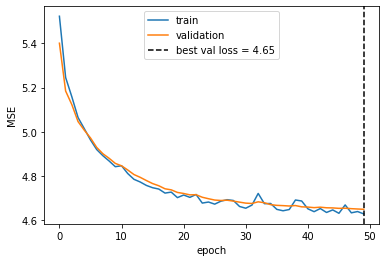

In [16]:
    
plot_history(NN1)

When performing stochastic gradient descent, batch size is another hyperparameter. It is, after, what makes the optimizer "stochastic!" The smaller the batches, the noiser the approximations of the gradient. 

Note that rather than re-creating the original network each time, we simply load the weights that were stored upon initialization. Less code to type!

**Batch Size**

CPU times: total: 1min 27s
Wall time: 1min 12s


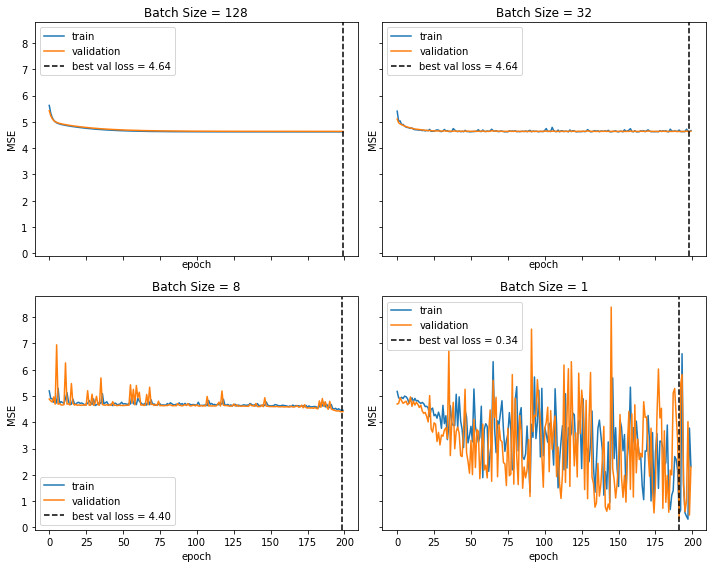

In [17]:
%%time
fig, axs = plt.subplots(2,2, figsize=(10,8), sharex=True, sharey=True)
axs = axs.flatten()
batch_sizes = [128, 32, 8, 1]
for ax, batch_size in zip(axs, batch_sizes):
    NN1.load_weights('NN1_init.h5')
    NN1.compile(optimizer=SGD(learning_rate=0.01, momentum=0, nesterov=False),
                loss='mse')

    NN1.fit(x_train, y_train, 
            validation_data=(x_test, y_test),
            batch_size=batch_size,
            epochs=200,
            verbose=0)
    
    plot_history(NN1, title=f'Batch Size = {batch_size}', ax=ax)
plt.tight_layout()

**Learning Rate**

Vanilla SGD has a fixed learning rate. Let's see how adjusting it as a hyperparameter affects the performance of our model.

CPU times: total: 34.9 s
Wall time: 27.5 s


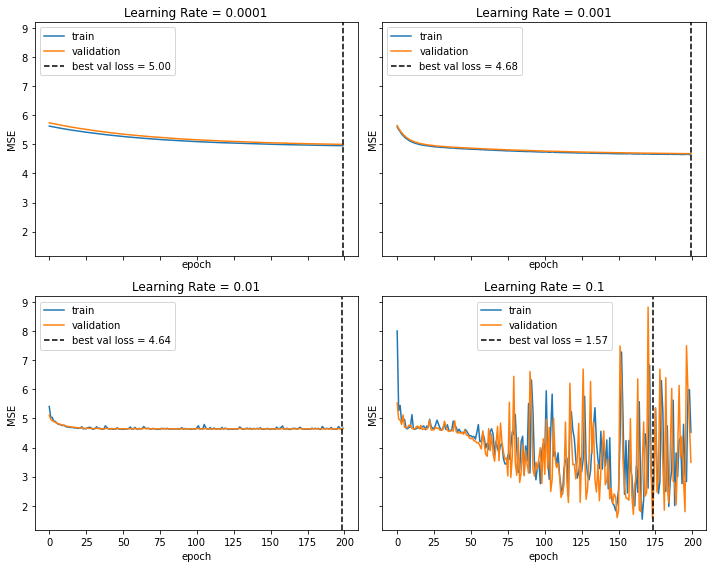

In [18]:
%%time
fig, axs = plt.subplots(2,2, figsize=(10,8), sharex=True, sharey=True)
axs = axs.flatten()
lrs = [1e-4, 1e-3, 1e-2, 0.1]
for ax, lr in zip(axs, lrs):
    NN1.load_weights('NN1_init.h5')
    NN1.compile(optimizer=SGD(learning_rate=lr, momentum=0, nesterov=False),
                loss='mse')

    NN1.fit(x_train, y_train, 
            validation_data=(x_test, y_test),
            batch_size=32,
            epochs=200,
            verbose=0)
    
    plot_history(NN1, title=f'Learning Rate = {lr}', ax=ax)
plt.tight_layout()

Clearly some of these learning rates are too low, causing the loss to decrease very slowly as the weight updates are being scaled down considerably. The learning rate of 0.1 reaches a much lower loss, but it starts to oscillate wildly, apparently bouncing in and out of minima because of the high learning rate.

**Learning rate decay / scheduling**

You can use a learning rate schedule to modulate how the learning rate of your optimizer changes over time. You can find more info on schedulers in the [Keras documentation](https://keras.io/api/optimizers/learning_rate_schedules/)

Here we will use [`ExponentialDecay`](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/) to shrink the learning rate over the course of training.

In [19]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

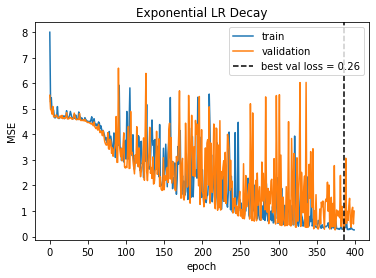

In [20]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=100,
    decay_rate=0.85)

NN1.load_weights('NN1_init.h5')
NN1.compile(optimizer=SGD(learning_rate=lr_schedule),
            loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=400,
        verbose=0);

plot_history(NN1, title=f'Exponential LR Decay')

If we were to incorporate information about **past updates**, might that help us converge faster?

**Momentum**
Momentum is the first method for using such past information in our updates. This helps us move along with the general trajectory we've taken so far, with oscillations cancelling themselves out.
$$L(W)$$
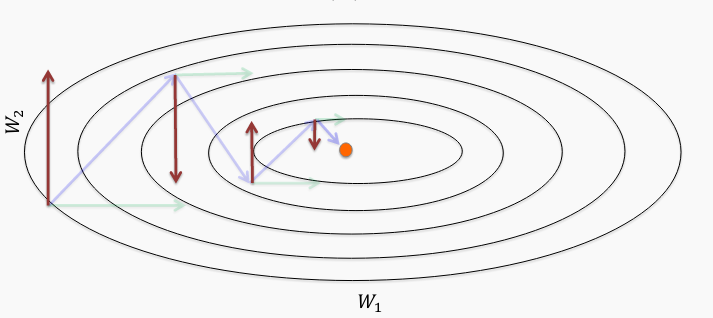

Updates are made using a weighted average of the current gradient, $g$, and the average "trend" seen so far, $v$.\
$v = \alpha v + (1-\alpha)g$

$W^* = W - \eta v$

CPU times: total: 34.2 s
Wall time: 27.8 s


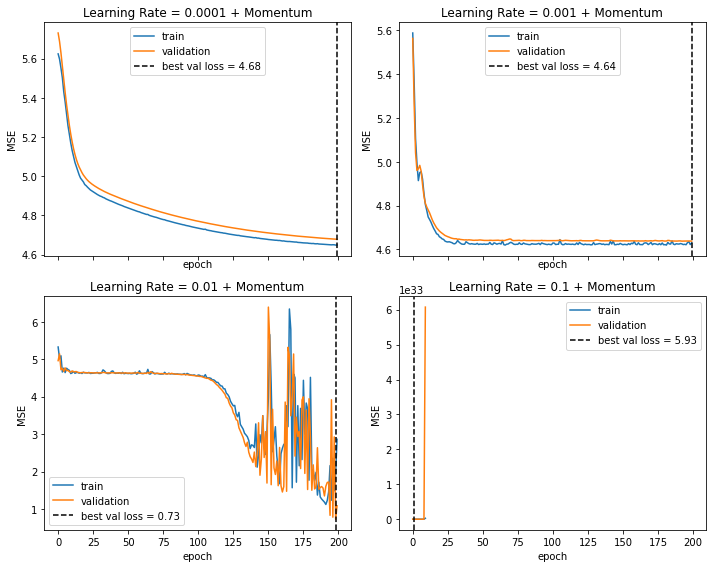

In [21]:
%%time
fig, axs = plt.subplots(2,2, figsize=(10,8), sharex=True)
axs = axs.flatten()
lrs = [1e-4, 1e-3, 1e-2, 0.1]
for ax, lr in zip(axs, lrs):
    NN1.load_weights('NN1_init.h5')
    NN1.compile(optimizer=SGD(learning_rate=lr, momentum=0.9, nesterov=False),
                loss='mse')

    NN1.fit(x_train, y_train, 
            validation_data=(x_test, y_test),
            batch_size=32,
            epochs=200,
            verbose=0)
    
    plot_history(NN1, title=f'Learning Rate = {lr} + Momentum', ax=ax)
plt.tight_layout()

What happened in the 4th example above? Let's train again with those parameters and look at the detailed output from each epoch.

In [22]:
# Inspect strange behavior in 4th plot above
NN1.load_weights('NN1_init.h5')
NN1.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, nesterov=False),
            loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=15,
        verbose=1)

Epoch 1/15
3/3 [==============================] - 0s 53ms/step - loss: 7.0072 - val_loss: 6.4655
Epoch 2/15
3/3 [==============================] - 0s 36ms/step - loss: 5.5418 - val_loss: 5.9347
Epoch 3/15
3/3 [==============================] - 0s 20ms/step - loss: 10.0591 - val_loss: 6.1523
Epoch 4/15
3/3 [==============================] - 0s 29ms/step - loss: 15.9397 - val_loss: 188.1036
Epoch 5/15
3/3 [==============================] - 0s 16ms/step - loss: 65836.8906 - val_loss: 5894046.5000
Epoch 6/15
3/3 [==============================] - 0s 20ms/step - loss: 3131821824.0000 - val_loss: 731959918592.0000
Epoch 7/15
3/3 [==============================] - 0s 27ms/step - loss: 943046170509312.0000 - val_loss: 220918617896648704.0000
Epoch 8/15
3/3 [==============================] - 0s 23ms/step - loss: 284624716884420329472.0000 - val_loss: 66676413979968770408448.0000
Epoch 9/15
3/3 [==============================] - 0s 25ms/step - loss: 85903609459189883185659904.0000 - val_loss: 20

It looks like the combination of high learning rate and momentum caused a numerical overflow, likely from hitting very 'steep' parts of the loss surface. It is bad news once you get a `nan` in your computations. As you can see, the network weights have all become `nan` as well!

In [23]:
# Ouch! Numerical overflow did in our network
NN1.get_weights()

[array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       dtype=float32),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        na

We take steps to prevent outcomes like this though.

**Gradient Clipping**

The Keras optimizers have clipping aguments 'hidden in the `*kwargs` designation of their docstrings.

Here we use `clipnorm` prevent giant gradients (and thus giant weight updates) from causing problems.

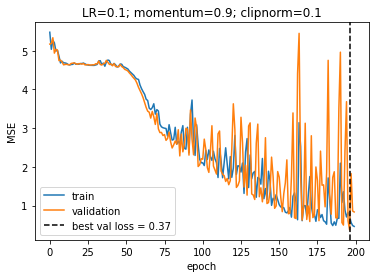

In [24]:
NN1.load_weights('NN1_init.h5')
NN1.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, nesterov=False, clipnorm=.1),
            loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=200,
        verbose=0);

plot_history(NN1, title=f'LR=0.1; momentum=0.9; clipnorm=0.1')

So far, the learning rate in our optimizer has been treating all weights equally. But this doesn't have to be the case.

---

[**Adagrad**](https://keras.io/api/optimizers/adagrad/)

Adagrad is an optimizer with parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training. The more updates a parameter receives, the smaller the updates.

![image-2.png](attachment:image-2.png)

A weight's learning rate is inversely proportional to the root of its accumulated squared component of the gradient seen thus far.

$r^*_i = r_i + g^2_i$

$W^*_i = W_i - \frac{\epsilon}{\delta + \sqrt{r_i}}g_i$
```{python}
tf.keras.optimizers.Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    name="Adagrad",
    **kwargs
)
```
[Duchi et al., 2011](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

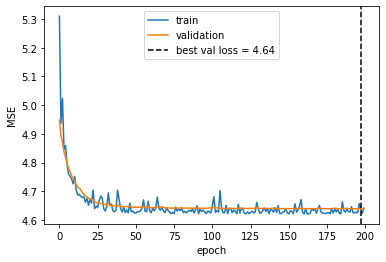

In [25]:
NN1.load_weights('NN1_init.h5')
NN1.compile(optimizer=Adagrad(learning_rate=0.01),
            loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=200,
        verbose=0)

plot_history(NN1)

As you can see, there is a problem with this approach. The accumulated gradients can quickly shrink the learning rates to the point where the network is not longer learning anything.

But we have a fix for this!

---

[**RMSPromp**](https://keras.io/api/optimizers/rmsprop/)

RMSprop maintains a moving (discounted) average of the square of gradients and divides the current gradient by the root of this average (RMS = root mean square).

$r^*_i = \rho r_i + (1-\rho)g^2_i$

$W^*_i = W_i - \frac{\epsilon}{\delta + \sqrt{r_i}}g_i$

```{python}
tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop",
    **kwargs
)
```
[Hinton, 2012](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)

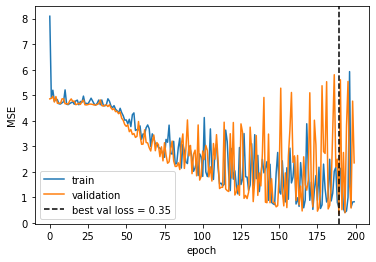

In [26]:
NN1.load_weights('NN1_init.h5')
NN1.compile(optimizer=RMSprop(learning_rate=0.01, rho=0.9, momentum=0.0),
            loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=200,
        verbose=0)

plot_history(NN1)

This works well, but can we also have it use information about the general trajectory or "trend" like momentum?

---

[**Adam**](https://keras.io/api/optimizers/adam/)

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments (Basically, momentum + RMSProp).
```{python}
tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
    **kwargs
)
```
[Kingma et al., 2014](http://arxiv.org/abs/1412.6980)

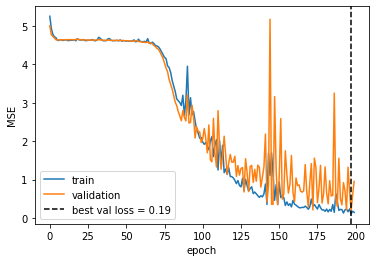

In [27]:
NN1.load_weights('NN1_init.h5')
NN1.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=200,
        verbose=0)

plot_history(NN1)

Very nice. Perhaps the lowest MSE we've seen so far. How does the fit look?

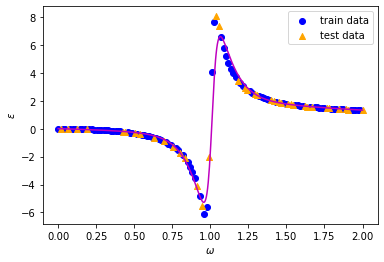

In [28]:
plot_lorentz(df, test_idx=x_test.index)
ax = plt.gca()
x_lin = np.linspace(df.x.min(), df.x.max(), (500)).reshape(-1,1)
y_hat = NN1.predict(x_lin)
ax.plot(x_lin, y_hat, c='m');

Much better than our original polynomial model!

---

**Other Optimizer Implementations Available in Keras:**
- [**Adadelta**](https://keras.io/api/optimizers/adadelta/)
    - Improvement on Adagrad. Adapts learning rates based on a moving window instead of accumulating all past gradients.
- [**Adamax**](https://keras.io/api/optimizers/adamax/)
    - Variant of Adam based on infinity norm (i.e., max).
- [**Nadam**](https://keras.io/api/optimizers/Nadam/)
    - Variant of Adam using nesterov momentum
- [**Ftrl**](https://keras.io/api/optimizers/ftrl/)
    - Implements the "[Follow The Regularized Leader](https://research.google.com/pubs/archive/41159.pdf)" algorithm.

## Overfitting

So far we've been looking at an oversimplified dataset where all the datapoints are right on top of the true generating function. But the real world is noisy!

In [29]:
df2 = pd.read_csv('data/lorentz_noise_set2.csv')
df2 = df2.sample(frac=1, random_state=109) # shuffle DataFrame!
x_train, x_test, y_train, y_test = train_test_split(df2.x, df2.y, train_size=0.7, random_state=109)

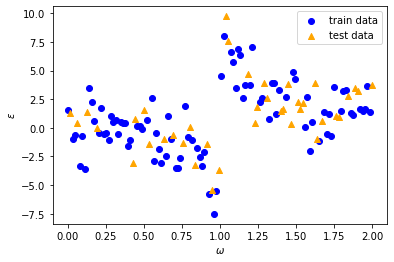

In [30]:
plot_lorentz(df2, x_test.index)

How does our previously best performing model fair on this more realistic dataset?

CPU times: total: 1min 23s
Wall time: 1min 4s


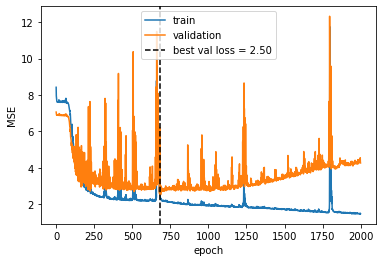

In [31]:
%%time
inputs = Input(shape=(1,))
x = Dense(50, activation='tanh')(inputs)
x = Dense(50, activation='tanh')(x)
outputs = Dense(1, activation='linear')(x)
NN2 = Model(inputs=inputs, outputs=outputs)
NN2.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN2.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=2000,
        verbose=0)

plot_history(NN2);

There are clear signs of overfitting as the validation error starts to diverge from the train error. Any "improvement" seen with respect to the training data after a certain point no longer generalizes. And after a while, we actually start to see the validation loss increasing.

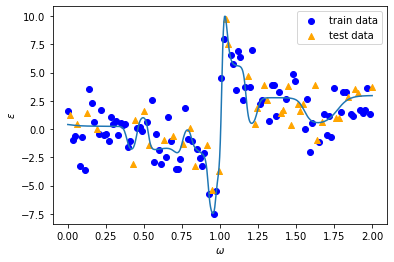

In [32]:
# Plot the overfit predictions
plot_lorentz(df2, test_idx=x_test.index)
ax = plt.gca()
x_lin = np.linspace(df2.x.min(), df2.x.max(), (500)).reshape(-1,1)
y_hat = NN2.predict(x_lin)
ax.plot(x_lin, y_hat);

And here we can see the model predictions jump around as it tries to fit the sparse and noisy points in the training data.\
Luckily we have several tools at our disposal for addressing overfitting in neural networks.

## Regularization

<div class='exercise'><b>Early Stopping (Keras Callbacks)</b></div></br>

Training a NN can take a long time. We should checkpoint our model so we don't lose progress and stop early if we don't see improvement to help save on training time. This motivates [Keras Callbacks](https://keras.io/api/callbacks/).

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

[`EarlyStopping`](https://keras.io/api/callbacks/early_stopping/) allows us to end the training process if we haven't seen an improvment in some loss or metric of our choice (`monitor`) for some number of epochs (`patience`). This even gives us the option of reverting back to the best state of the network (according to the chosen metric) when training ends.

In [34]:
es = EarlyStopping(monitor='val_loss', patience=75, restore_best_weights=True, verbose=1)

[`ModelCheckpoint`](https://keras.io/api/callbacks/model_checkpoint/) let's us save our models to disk periodically. For example, you might want to update your saved model file each time there is an improvement. Just image hwo sad it would be if your kernel diedd or there was some other failure thousands of epochs into the training process. Checkpointing can prevent these tragedies.

In [35]:
# checkpointing actually slows down training
# just add it to the call back list if you'd like to include it
mc = ModelCheckpoint('data/models', monitor='val_loss', save_best_only=True, save_weights_only=False)

We can also execute arbitrary functions at different the start/end of a batch/eepoch using the [`LambdaCallback`](https://keras.io/api/callbacks/lambda_callback/).

In [36]:
lcall = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f'epoch {epoch}') if epoch % 50 == 0 else None)

Any callbacks we wish to use during training are passed as a list to the `fit` function's `callbacks` argument.

epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
Restoring model weights from the end of the best epoch: 218.
Epoch 293: early stopping
CPU times: total: 12.7 s
Wall time: 10.3 s


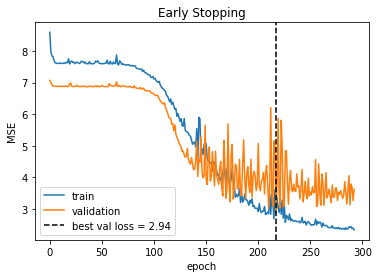

In [37]:
%%time
inputs = Input(shape=(1,))
x = Dense(50, activation='tanh')(inputs)
x = Dense(50, activation='tanh')(x)
outputs = Dense(1, activation='linear')(x)
NN_es = Model(inputs=inputs, outputs=outputs)
NN_es.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN_es.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=2000,
        callbacks=[es, lcall],
        verbose=0)
plot_history(NN_es, title="Early Stopping")

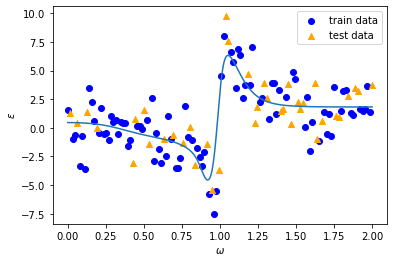

In [38]:
plot_lorentz(df2, test_idx=x_test.index)
ax = plt.gca()
x_lin = np.linspace(df2.x.min(), df2.x.max(), (500)).reshape(-1,1)
y_hat = NN_es.predict(x_lin)
ax.plot(x_lin, y_hat);

### Weight Decay

In [39]:
from tensorflow.keras.regularizers import L1, L2

We can also and a penalty term to our loss function that penalizes the model based on the magnitutes of its weights. This forces the network to balance goodness-of-fit to the training data and model complexity, reducing the possibility of overfitting.

**$L_2$ Regularization**

Penalty based on the square of network weights.

CPU times: total: 1min 31s
Wall time: 1min 12s


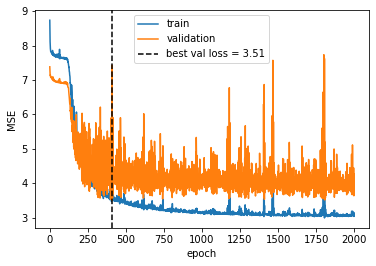

In [40]:
%%time
kernel_regularizer = L2(0.005)
bias_regularizer = L2(0.005)
inputs = Input(shape=(1,))
x = Dense(50, activation='tanh',
          kernel_regularizer=kernel_regularizer,
          bias_regularizer=bias_regularizer)(inputs)
x = Dense(50, activation='tanh',
          kernel_regularizer=kernel_regularizer,
          bias_regularizer=bias_regularizer)(x)
outputs = Dense(1, activation='linear')(x)
NN1 = Model(inputs=inputs, outputs=outputs)
NN1.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=2000,
#         callbacks=[es, lcall],
        verbose=0)
plot_history(NN1)

**$L_1$ Regularization**

Penalty based on the absolute value of model weights. Like LASSO in linear regression, this tends to push some weights to zero, resulting in "sparsity" (i.e., some nodes are "off" in the network).

CPU times: total: 1min 33s
Wall time: 1min 13s


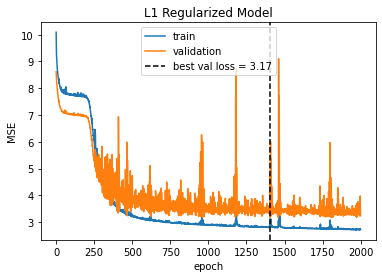

In [41]:
%%time
kernel_regularizer = L1(0.005)
bias_regularizer = L1(0.005)
inputs = Input(shape=(1,))
x = Dense(50, activation='tanh',
          kernel_regularizer=kernel_regularizer,
          bias_regularizer=bias_regularizer)(inputs)
x = Dense(50, activation='tanh',
          kernel_regularizer=kernel_regularizer,
          bias_regularizer=bias_regularizer)(x)
outputs = Dense(1, activation='linear')(x)
NN_L1 = Model(inputs=inputs, outputs=outputs)
NN_L1.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN_L1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=2000,
#         callbacks=[es, lcall],
        verbose=0)
plot_history(NN_L1, title='L1 Regularized Model')

### [Dropout](https://keras.io/api/layers/regularization_layers/dropout/)

In [42]:
from tensorflow.keras.layers import Dropout

The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by `1/(1 - rate)` such that the sum over all inputs is unchanged.

Note that the Dropout layer only applies during training and no values are dropped during inference. 

Even if individual weight magnitudes are constrained with methods like weight decay above, many weights can "conspire" within a network to collectively have a large effect. Dropout helps prevent this because no weight can "rely" on any other for its affect as it may be turned off. 

You can also think of dropout as turning your network into a aggregated ensemble of smaller neural networks! 

CPU times: total: 1min 26s
Wall time: 1min 11s


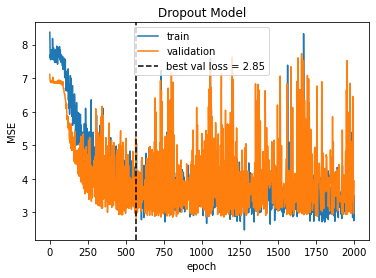

In [43]:
%%time
dropout_rate = 0.2
inputs = Input(shape=(1,))
x = Dense(50, activation='tanh')(inputs)
x = Dropout(dropout_rate)(x)
x = Dense(50, activation='tanh')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation='linear')(x)
NN_do = Model(inputs=inputs, outputs=outputs)
NN_do.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN_do.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=2000,
#         callbacks=[es, lcall],
        verbose=0)
plot_history(NN_do, title='Dropout Model')

## Batch Normalization (Batchnorm) 

When we have inputs on different scales we are advised to standardize them to put everything on the same scale.\
But now consider that from the perspective of the 2nd layer in your network, the outputs of the first layer are its input features. Should these be standardized for the same reasons we standardize the input to the first layer?

Batch Normalization extends the idea of feature rescaling to (potential) all the layers in your network.

The "batch" in the name refers to the fact the the mean and standard deviation used for the standardization are "noisy" approximations calculated from the current mini-batch. This "noisiness" can have a *slight* regularization effect.

More importantly, it helps keep the distribution of input values going into a given layer from shifting around. Your layer is trying to learn weights to map its input to the appropriate input, but this is made very difficult if the input values look wildly different after weights in the previous layers are also updated; it's like trying to hit a moving target.

Batchnorm is normally placed *between* the affine transformation of a neuron and its activation function.
A batchnorm layer has two trainable parameters which allow the network to learn what the ideal mean and standard deviation are for the data to possess before being passed through the activation function. Consider why this might be important for certain activation functions like relu or sigmoid.

If we want to put a batchnorm layer before our activation functions then we can forego specifying an activation in the `Dense` layer and instead use an `Activation` layer!

In [44]:
from tensorflow.keras.layers import Activation, BatchNormalization

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_37 (Dense)            (None, 20)                40        
                                                                 
 batch_normalization (BatchN  (None, 20)               80        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20)                0         
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_38 (Dense)            (None, 20)                420       
                                                           

None

epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
epoch 300
epoch 350
epoch 400
epoch 450
epoch 500
epoch 550
epoch 600
epoch 650
epoch 700
epoch 750
epoch 800
epoch 850
epoch 900
Restoring model weights from the end of the best epoch: 665.
Epoch 915: early stopping
CPU times: total: 1min 4s
Wall time: 52.4 s


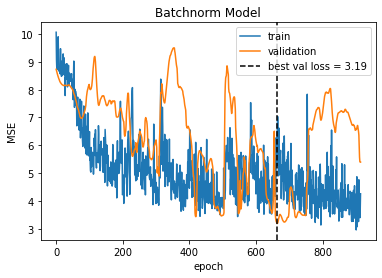

In [45]:
%%time
n_nodes = 20
noise_stddev = 0.2
dropout_rate = 0.20
activation='relu'
inputs = Input(shape=(1,))
x = Dense(n_nodes, activation=None)(inputs)
x = BatchNormalization()(x)
x = Activation(activation)(x)
x = Dropout(dropout_rate, seed=109)(x)
for i in range(10):
    x = Dense(n_nodes, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate, seed=209+i)(x)
outputs = Dense(1, activation='linear')(x)
NN_bn = Model(inputs=inputs, outputs=outputs)
display(NN_bn.summary())
NN_bn.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN_bn.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=512,
        epochs=2000,
        callbacks=[EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True, verbose=1),
                   lcall],
        verbose=0)
plot_history(NN_bn, title='Batchnorm Model')

### Data Augmentation

In [46]:
from tensorflow.keras.layers import GaussianNoise

The easiest way to fix overfitting is to use more data. This isn't always an option, but we can often "fake it" with some success. The idea behind **data augmentation** is to produce variations of your existing data that are still close enough to real examples. In this way the model becomes less sensitive to any of the idiosyncratic features of your particular training examples and instead will learn what is essential and common across all your generated data.

Perhaps the easiest form of data augmentation is simply adding a bit of gaussian noise to your data points.\
This is made very easy with Keras's [`GaussianNoise`](https://keras.io/api/layers/regularization_layers/gaussian_noise/) layer. Just specify a stddev for the noise distribution. And keep in mind that it can take a random seed!

CPU times: total: 1min 26s
Wall time: 1min 8s


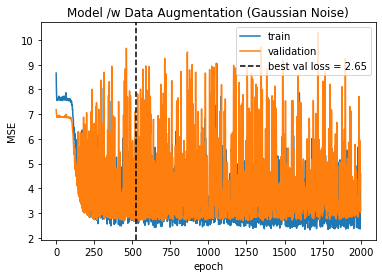

In [47]:
%%time
noise_stddev = 0.025
inputs = Input(shape=(1,))
x = GaussianNoise(stddev=noise_stddev, seed=109)(inputs)
x = Dense(50, activation='tanh')(x)
x = Dense(50, activation='tanh')(x)
outputs = Dense(1, activation='linear')(x)
NN_da = Model(inputs=inputs, outputs=outputs)
NN_da.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN_da.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=2000,
#         callbacks=[es, lcall],
        verbose=0)
plot_history(NN_da, title='Model /w Data Augmentation (Gaussian Noise)')

## Part 2 - Classification with Neural Networks

In this 2nd half of the lab we will be working with the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).
<img src="https://4.bp.blogspot.com/-OQZGt_5WqDo/Wa_Dfa4U15I/AAAAAAAAAUI/veRmAmUUKFA19dVw6XCOV2YLO6n-y_omwCLcBGAs/s400/out.jpg" width="400px" />

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

We will be using a very small fraction of the dataset. The goal is to first overfit a NN to this classification task and then use the tools explored in the 1st half of the notebook to regularize and improve the model through hyperparameter tweaking.

But first, we will explore a new option for **image data augmentation** through the use of Keras's `ImageDataGenerator` ojects which may be useful to us.

## Datagenerators in Keras

This section shows how to build data generators from a collection of image files to be used for training a Keras model. The process of creating the file structure required by data generators is normally quite tedious. The code below can be adapted and reused for your own projects to save you a lot of time!

[(keras ImageGenerator documentation)](https://keras.io/preprocessing/image/)

Fashion-MNIST and other pre-loaded dataset are formatted in a way that is almost ready for feeding into a model. But what about your average image files? They should be appropriately preprocessed into floating-point tensors before being fed into the network.

Imagine you have a bunch of dogs and cat images you want to prepare for a Keras model using a `ImageDataGenerator`</br>
We need to create:
1. train, validation, and test directories, each containing a subset of the images.
2. separate cat and dog directories _within_ train, validation, and test
Number 2 is necessary because the Keras ImageDataGenerator infers the class label from the subdirectory the image resides in.

The directory structure should then look like this:

```
 dogs_vs_cats
 ├── test
 │   ├── cats
 │   └── dogs
 ├── train
 |   ├── cats
 |   └── dogs
 └── validation
     ├── cats
     └── dogs
```

This is what we will do for the `Fashion-MNIST` data. It would be a lot of work to do it manually, especially with 10 classes! But it isn't to difficult to take care of all of this programatically.

In [48]:
# Load entire Fashion-MNIST dataset from Tensorflow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


These are the 10 class labels and the integer they map to in `y_train` and `y_test`.

In [49]:
# Fashion-MNIST class labels
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
label2idx = {label: idx for idx, label in enumerate(labels)}
label2idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Here's some examples from the dataset.

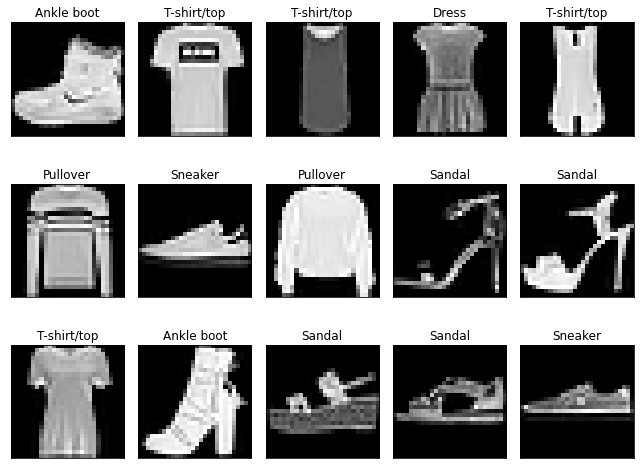

In [50]:
# Fashion-MNIST examples
fig, axs = plt.subplots(3,5, figsize=(9,7))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(x_train[i], cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(labels[y_train[i]])
plt.tight_layout()

In [51]:
# Dataset size
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

Because our goal is to first overfit (and have a model we can train multiple times as we experiment in a 75 minute lab!) we will discard most of the training data. We do stratified splits to avoid biasing our sample. The classes are equally represented in the original dataset.

In [52]:
# Throw away most of the training data to make things more difficult
# We'll also toss most of the test data (writing it all to disk is slow on JupyterHub!)
_, x_test, _, y_test = train_test_split(x_test, y_test, test_size=0.10, stratify=y_test)
x_train, _, y_train, _ = train_test_split(x_train, y_train, train_size=0.02, stratify=y_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

In [53]:
# Sample size
x_train.shape, x_val.shape, x_test.shape

((960, 28, 28), (240, 28, 28), (1000, 28, 28))

The `PIL` module (Python Image Library) is useful for taking the numpy arrays that currently represent the images and writing them to disk as jpeg files. 

In [54]:
from PIL import Image

In [55]:
DATA_DIR = 'data/fashionMNIST' # create path name for data

In [56]:
data = {'train': (x_train, y_train),
        'validation': (x_val, y_val),
        'test': (x_test, y_test)}

In [57]:
%%time
# Construct directory structure and write image files to disk
if not os.path.isdir(DATA_DIR):
    os.makedirs(DATA_DIR, exist_ok=True)

    for split, (x, y) in data.items():
        for label in labels:
            label_s = label.replace('/','_')
            new_dir = os.path.join(DATA_DIR, split, label_s)
            os.makedirs(new_dir, exist_ok=True)
            target = label2idx[label]
            cur_images = x[y==target]
            for i in range(cur_images.shape[0]):
                im = Image.fromarray(cur_images[i]).convert("L")
                filename = f"{label_s}_{split}_{i:04d}"
                im.save(f"{DATA_DIR}/{split}/{label_s}/{filename}.jpeg")

CPU times: total: 0 ns
Wall time: 0 ns


In [58]:
# number of images in each subdir
for dir_name in data.keys():
    print(dir_name)
    for label in labels:
        label_dir = label.replace('/','_')
        print('\t'+label_dir, len(os.listdir(DATA_DIR + '/' + dir_name + '/' + label_dir)))

train
	T-shirt_top 96
	Trouser 96
	Pullover 96
	Dress 96
	Coat 96
	Sandal 96
	Shirt 96
	Sneaker 96
	Bag 96
	Ankle boot 96
validation
	T-shirt_top 24
	Trouser 24
	Pullover 24
	Dress 24
	Coat 24
	Sandal 24
	Shirt 24
	Sneaker 24
	Bag 24
	Ankle boot 24
test
	T-shirt_top 100
	Trouser 100
	Pullover 100
	Dress 100
	Coat 100
	Sandal 100
	Shirt 100
	Sneaker 100
	Bag 100
	Ankle boot 100


<div class='exercise'><b>Create the Generators</b></div></br>

Now that we have the data in the correct directory structure we can create the data generators.</br>
Yes, that's correct. We will have _multiple_ generators, one for each split directory.</br>
First we create a a main data generator object, `datagen`. This can be a given a wide range of arguments which can be used to preprocess the images it generates.</br>
For right now we will only use the `rescale` argument to normalize all pixel values to between 0 and 1 (remamber that 255 is the max pixel value).

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

The `ImageDataGenerator` can automate the scaling of normalizing the image pixel values to [0,1]. THis is just a first glipse of how these objects can help with a preprocessing and training pipeline!

In [60]:
datagen = ImageDataGenerator(rescale=1./255)

Now we use `datagen`'s `flow_from_directory` method to create the 3 generators: `traingen`, `valgen`, and `testgen`.</br>
The need to be given the `directory` which they will use as their image source, a `target_size` to resize all images to (e.g., (14,14)), a `batch_size`, and `class_mode` to instruct the generator on how to interpret the label folders. We should probably also set `shuffle = False` in the test generator so it produces the same images in the same order everytime it is used. We also set `color_mode='grayscale'`. Otherwise the default is to output color images which would be of shape (28,28,3) because they have 3 color channels (more on that next lab!).

In [61]:
batch_size = 32
target_size = (28, 28) # generator can resize all images if we want
# this is the augmentation configuration we will use for training

traingen = datagen.flow_from_directory(
                                DATA_DIR+'/train',  # this is the target directory
                                target_size=target_size,  # all images will be resized to 150x150
                                batch_size=batch_size,
                                class_mode='categorical',  # since we use categorical_crossentropy loss, we need binary labels
                                 color_mode='grayscale')
valgen = datagen.flow_from_directory(
                                DATA_DIR+'/validation',
                                target_size=target_size, 
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='grayscale') 

testgen = datagen.flow_from_directory(
                        DATA_DIR+'/test',  
                        target_size=target_size, 
                        batch_size=batch_size,
                        shuffle = False,
                        class_mode='categorical',
                        color_mode='grayscale') 

Found 960 images belonging to 10 classes.
Found 240 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


Let’s look at the output of one of these generators to see how `target_size` and `batch_size` affects the output. Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, you need to break the iteration loop at some point if using a `for` loop. Better still, you can use the built in `next` function to return a signle element from the generator.

In [62]:
data_batch, labels_batch = next(traingen)
print('data batch shape:', data_batch.shape)
print('labels batch shape:', labels_batch.shape)

data batch shape: (32, 28, 28, 1)
labels batch shape: (32, 10)


<div class='exercise'><b>Construct a Classifier NN</b></div></br>

Let's built our first attempt at a clothing classifier and try to overfit.

Note that Keras has a `Flatten` layer! We can use this to automatically turm input images into 1D arrays.\
(We'll see how to handle 2D input in future lectures and labs) 

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Activation, Input, BatchNormalization, Dense, Dropout, Flatten, GaussianNoise
from tensorflow.keras.optimizers import Adam, SGD

In [64]:
# Overfit Fashion-MNIST Classifier
input_dim = data_batch.shape[1:]
n_classes = labels_batch.shape[-1]
inputs = Input(shape=(input_dim))
flat = Flatten()(inputs)
x = Dense(256, activation=None, kernel_initializer='he_uniform')(flat)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(128, activation=None, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(64, activation=None, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(32, activation=None, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(n_classes, activation=None, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
outputs = Activation('softmax')(x)
NN = Model(inputs, outputs)
NN.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
NN.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_52 (Dense)            (None, 256)               200960    
                                                                 
 batch_normalization_11 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 256)               0         
                                                                 
 dense_53 (Dense)            (None, 128)               32896     
                                                           

<div class='exercise'><b>Keras Callbacks</b></div></br>

We'll use early stopping with short patience so we can call it quits early when it looks like we are overfitting so we can save time.

In [65]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [es]

<div class='exercise'><b>Fit Model with Generator</b></div></br>

Let’s fit the model to the data using the generator. You can use `fit` as before but this time you will pass it generators rather than dataframes or numpy arrays.  

Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn steps_per_epoch batches from the generator—that is, after having run for steps_per_epoch gradient descent steps - the fitting process will go to the next epoch. 

When using `fit`, you can pass a validation_data argument, much as with the fit method. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation

In [66]:
%%time
history = NN.fit(
        traingen,
        steps_per_epoch=traingen.samples//traingen.batch_size,
        epochs=30,
        validation_data=valgen,
        validation_steps=valgen.samples//valgen.batch_size,
        callbacks=callbacks,
        workers=-1,
        use_multiprocessing=True,
        verbose=1)

Epoch 1/30
30/30 [==============================] - 2s 40ms/step - loss: 1.4754 - accuracy: 0.5667 - val_loss: 1.6293 - val_accuracy: 0.4866
Epoch 2/30
30/30 [==============================] - 1s 26ms/step - loss: 0.9864 - accuracy: 0.7594 - val_loss: 1.4936 - val_accuracy: 0.5804
Epoch 3/30
30/30 [==============================] - 1s 26ms/step - loss: 0.8432 - accuracy: 0.8135 - val_loss: 1.2674 - val_accuracy: 0.6830
Epoch 4/30
30/30 [==============================] - 1s 26ms/step - loss: 0.7248 - accuracy: 0.8615 - val_loss: 1.1850 - val_accuracy: 0.7188
Epoch 5/30
30/30 [==============================] - 1s 26ms/step - loss: 0.7161 - accuracy: 0.8656 - val_loss: 1.0775 - val_accuracy: 0.7321
Epoch 6/30
30/30 [==============================] - 1s 26ms/step - loss: 0.6123 - accuracy: 0.9000 - val_loss: 1.0310 - val_accuracy: 0.7366
Epoch 7/30
30/30 [==============================] - 1s 26ms/step - loss: 0.5945 - accuracy: 0.9000 - val_loss: 0.9522 - val_accuracy: 0.7500
Epoch 8/30
30

<div class='exercise'><b>Evaluate the Model</b></div></br>

In [67]:
NN.evaluate(traingen)

30/30 [==============================] - 0s 10ms/step - loss: 0.1741 - accuracy: 0.9833


[0.17405518889427185, 0.9833333492279053]

In [68]:
NN.evaluate(valgen)

8/8 [==============================] - 0s 14ms/step - loss: 0.7311 - accuracy: 0.7833


[0.7310953736305237, 0.7833333611488342]

In [69]:
NN.evaluate(testgen)

32/32 [==============================] - 1s 41ms/step - loss: 0.7693 - accuracy: 0.7820


[0.7693048119544983, 0.7820000052452087]

Let’s plot the loss and accuracy of the model over the training and validation data during training:

<div class='exercise'><b>Plot the Training History</b></div></br>

Final Val Acc: 0.77


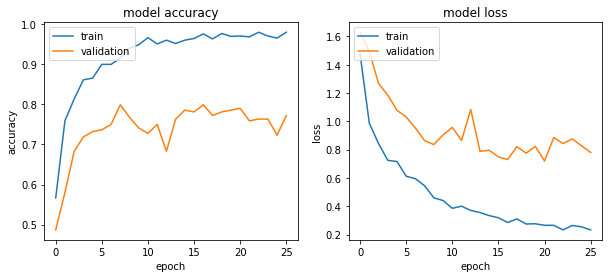

In [70]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
print(f"Final Val Acc: {history.history['val_accuracy'][-1]:.2f}")
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left');


## Part 2: Now with Data Augmentation

We saw in the lecture on regularization that we can slightly alter our training data to similuate a larger dataset. These means our model is less likely to overfit as there is more it would have to 'memorize.'

Take a look again at the [ImageDataGenerator Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to see what choices we have for changing our data. Are all changes appropriate here?</br>
Create a new data generator `datagen_aug` that preprocesses images with your chosen changes. Then we only need to make a new `traingen_aug` using `flow_from_directory`.

The `preprocessing_function` argument can be passed an arbitrary function to act on images pulled from the generator. Here we provide an example of a function to add Gaussian noise.

<div class='exercise'><b>Create Augmenting Generator</b></div></br>

In [71]:
# your code here
def add_noise(img):
    VARIABILITY = 20 # customize this
    deviation = VARIABILITY*np.random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.clip(img, 0., 255.)
    return img

datagen_aug = ImageDataGenerator(
      rescale=1./255,
      ## customize these and other parameters
      # rotation_range=0,
      # width_shift_range=0,
      # height_shift_range=0,
      # shear_range=0,
      # zoom_range=0,
      preprocessing_function=add_noise,
      # horizontal_flip=True,
      # fill_mode='nearest',
)

# We don't want to augment the validation (or test) data
traingen_aug = datagen_aug.flow_from_directory(
    DATA_DIR+'/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 960 images belonging to 10 classes.


These are just a few of the options available (for more, see the Keras documentation). 
Let’s quickly go over this code:

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.
- horizontal_flip is for randomly flipping half the images horizontally—relevant when there are no assumptions of - horizontal asymmetry (for example, real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift. 

Let’s look at some augmented images generated from a single source image.

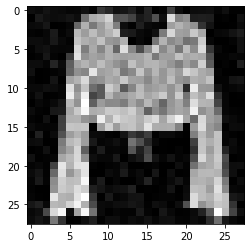

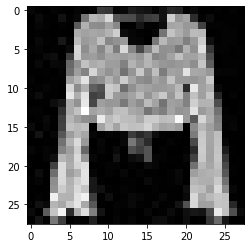

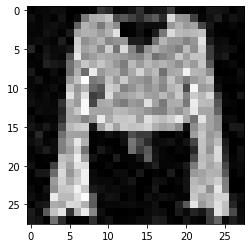

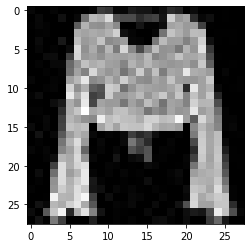

In [72]:
# Examples of augmented images
from tensorflow.keras.preprocessing import image
train_gb_dir = os.path.join(DATA_DIR, 'train', 'Shirt')
fnames = [os.path.join(train_gb_dir, fname) for fname in os.listdir(train_gb_dir)]
img_path = fnames[3] # Chooses one image to augment
img = image.load_img(img_path, target_size=target_size)
# Reads the image and resizes it
x = image.img_to_array(img) # Converts it to a Numpy array
x = x.reshape((1,) + x.shape) # Reshapes it 
i = 0
for batch in datagen_aug.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]).convert('L'), cmap='gray')
    i += 1
    if i % 4 == 0:
        break

plt.show()

Here you can generate a random augemented image.

(28, 28, 1)


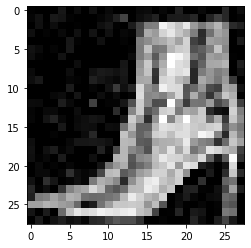

In [73]:
# Sample from augmented data generator
example = next(traingen_aug)[0][0]
print(example.shape)
plt.imshow(example, cmap='gray');

If you train a new network using this data-augmentation configuration, the network will never see the same input twice. But the inputs it sees are obviously very related, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting and improve the model, use all the tool at your disposal: activation functions, initializers, optimizers, regularization techniques, callbacks, and batchnorm!

<div class='exercise'><b>2nd FFN Model</b></div></br>
To see the affect of your choices, you should make several attempts in which you do not change the overall model architecture (i.e., number of layers and nodes).

In [75]:
# your code here
data_batch, labels_batch = next(traingen_aug)
print('data batch shape:', data_batch.shape)
print('labels batch shape:', labels_batch.shape)

input_dim = data_batch.shape[1:]
n_classes = labels_batch.shape[-1]

inputs = Input(shape=(input_dim))
flat = Flatten()(inputs)
x = Dense(256, activation=None)(flat)
x = Activation('relu')(x)
x = Dense(128, activation=None)(x)
x = Activation('relu')(x)
x = Dense(64, activation=None)(x)
x = Activation('relu')(x)
x = Dense(32, activation=None)(x)
x = Activation('relu')(x)
x = Dense(n_classes, activation=None)(x)
outputs = Activation('softmax')(x)
NN_aug = Model(inputs, outputs)
NN_aug.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
NN_aug.summary()

data batch shape: (32, 28, 28, 1)
labels batch shape: (32, 10)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_57 (Dense)            (None, 256)               200960    
                                                                 
 activation_16 (Activation)  (None, 256)               0         
                                                                 
 dense_58 (Dense)            (None, 128)               32896     
                                                                 
 activation_17 (Activation)  (None, 128)               0         
                                                              

In [76]:
%%time
# your code here
history_aug = NN_aug.fit(
        traingen_aug,
        steps_per_epoch=traingen_aug.samples//traingen_aug.batch_size,
        epochs=100,
        validation_data=valgen,
        validation_steps=valgen.samples//valgen.batch_size,
        # callbacks=___,
        verbose=0)

# save model if needed
NN_aug.save('data/gen_model_aug.h5')

CPU times: total: 1min 10s
Wall time: 41.4 s


Final Val Acc: 0.81


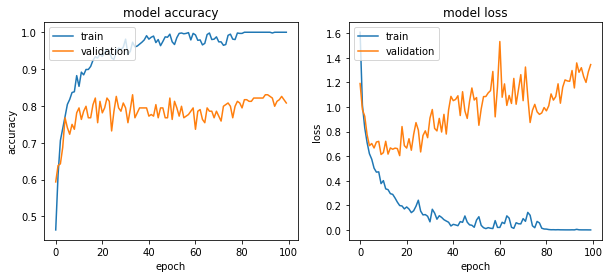

In [77]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
print(f"Final Val Acc: {history_aug.history['val_accuracy'][-1]:.2f}")
axs[0].plot(history_aug.history['accuracy'])
axs[0].plot(history_aug.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

# summarize history for loss
axs[1].plot(history_aug.history['loss'])
axs[1].plot(history_aug.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left');

In [78]:
NN_aug.evaluate(traingen)

30/30 [==============================] - 0s 11ms/step - loss: 2.0606e-04 - accuracy: 1.0000


[0.0002060593105852604, 1.0]

In [79]:
NN_aug.evaluate(valgen)

8/8 [==============================] - 0s 12ms/step - loss: 1.3043 - accuracy: 0.8125


[1.3043190240859985, 0.8125]

In [80]:
NN_aug.evaluate(testgen)

32/32 [==============================] - 0s 9ms/step - loss: 1.4370 - accuracy: 0.8090


[1.4369760751724243, 0.8090000152587891]

How high are you able to get the validation accuracy? (Can you beat 83%?) Does it translate well to test accuracy after all your optimization and tuning?